## **FINAL MODEL**   
#### OCR integrated with Translation Model

In [ ]:
import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLPFINAL/Hindi_English_Truncated_Corpus.csv')
df.head()

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [ ]:
df.drop(columns=['source'],inplace=True)

In [ ]:
df = df.iloc[:10000,:]
df.head()

,english_sentence,hindi_sentence
0,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [ ]:
def cleanerEng(x):
  x = str(x)
  x = x.lower()
  x = re.sub(r'[^a-z0-9]+',' ',x)
  if len(x) > 150:
    x = x[:150]
  return x

def cleanerHindi(x):
  x = str(x)
  x = re.sub(r'[-.।|,?;:<>&$₹]+',' ',x)
  if len(x) > 150:
    x = x[:150]
  return x

In [ ]:
df.iloc[:,0] = df['english_sentence'].apply(func=cleanerEng)
df.iloc[:,1] = df['hindi_sentence'].apply(func= cleanerHindi)
df.iloc[:,0] = df['english_sentence'].apply(func= lambda x : (str(x).split()))
df.iloc[:,1] = df['hindi_sentence'].apply(func= lambda x : (str(x).split()))

In [ ]:
def addTokens(x,start=False):
  x.append('<END>')
  if start:
    x.insert(0,'<START>')
  return list(x)

In [ ]:
df.iloc[:,0] = df['english_sentence'].apply(func= addTokens,start=False)
df.iloc[:,1] = df['hindi_sentence'].apply(func= addTokens,start=True)

In [ ]:
df.iloc[79,1]

['<START>',
 'जो',
 'वह',
 'सीखता',
 'है',
 'या',
 'पूर्व',
 'क्रमादेशित',
 'होता',
 'है',
 '<END>']

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random

In [ ]:
data = df.values

In [ ]:
data[:,1].shape

(10000,)

In [ ]:
class vocab:

  def __init__(self,data,token=True):
    self.data = data
    if token:
      self.word2idx = {'<START>':1, '<END>':2, '<PAD>':0}
      self.idx2word = {1:'<START>', 2:'<END>', 0:'<PAD>'}
      self.idx = 2

    else:
      self.word2idx = {'<PAD>':0, '<END>':1}
      self.idx2word = {0:'<PAD>', 1:'<END>'}
      self.idx = 1

    self.x = []
    self.create()
    self.vocab_size = self.idx + 1

  def create(self):
    max_len = 0;
    for sentence in  self.data:
      max_len = max(max_len, len(sentence))
      for word in sentence:
        if self.word2idx.get(word) is None:
          self.idx += 1
          self.word2idx[word] = self.idx
          self.idx2word[self.idx] = word
    
    for sentence in self.data:
      sent = []
      for word in sentence:
        sent.append(self.word2idx[word])
      
      for i in range(len(sentence),max_len+1):
        sent.append(0)
      
      self.x.append(torch.Tensor(sent))

In [ ]:
English_vocab = vocab(data[:,0],token=False)
Hindi_vocab = vocab(data[:,1],token=True)

In [ ]:
for idx in Hindi_vocab.x[2]:
  print(Hindi_vocab.idx2word[int(idx)],end=' ')

<START> यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

In [ ]:
class parallelData(Dataset):

  def __init__(self):
    self.x = English_vocab.x
    self.y = Hindi_vocab.x

  def __getitem__(self,i):
    return self.x[i], self.y[i]
  
  def __len__(self):
    return len(self.x)

In [ ]:
dataset = parallelData()

In [ ]:
a = dataset[0][0].shape[0]
b = dataset[0][1].shape[0]
for i in range(len(dataset)):
  if a != dataset[i][0].shape[0] or b != dataset[i][1].shape[0]:
    print(a,dataset[i][0].shape[0],b,dataset[i][1].shape[0])

In [ ]:
Hindi_vocab.x[90].shape

torch.Size([42])

In [ ]:
#Model preparation

class encoder(nn.Module):

  def __init__(self, input_size, embedding_size, hidden_size, layers, bidirectional):
    '''
    input_size = size of vocab
    embedding_size = embedding dim
    hidden_size = hidden state size
    layer = num of layers of lstms
    '''
    super().__init__()
    self.embed = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size) # output size = (*,embedding_size)
    self.lstm = nn.LSTM(input_size=embedding_size, hidden_size= hidden_size, num_layers=layers, batch_first = True, bidirectional = bidirectional)
    self.bidirectional = bidirectional
    #in order to convert bidirectional hidden state to unidirectional if LSTM is bidirectional 
    self.fc_hidden = nn.Linear(hidden_size*2, hidden_size)
    self.fc_cell = nn.Linear(hidden_size*2, hidden_size)

  def forward(self,x):
    '''
    x shape = [batch_size, sentence]
    one complete sentence represents a "sequence"
    '''
    x = self.embed(x) # shape [batch_size,  sentence, embed_size]
    output, (hidden_state, cell_state) = self.lstm(x) #shape [batch_size, seq_len, num_directions(2)*hidden_size]

    if self.bidirectional:  #since we have 2 directions so add(concat) hidden of both directions into one
      hidden = torch.cat((hidden_state[0:1], hidden_state[1:2]), dim=2)
      cell = torch.cat((cell_state[0:1], cell_state[1:2]), dim = 2) #output [1(layer), batch, hidden_size*2]
      hidden_state = self.fc_hidden(hidden)
      cell_state = self.fc_cell(cell)

    # print(output.shape, x.shape)
    #output shape = [batch_size, seq_len, 2*hidden_size] 
    #hidden shape =[1(layers), batch_size, hidden_size]
    return output, hidden_state, cell_state

##_---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
class decoder(nn.Module):

  def __init__(self,input_size, embedding_size, hidden_size, layers):
    '''
    same configuration as encoder
    here input_size = size of hindi vocab
    '''
    super().__init__()
    self.embed = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size) # output size = (*,embedding_size)
    self.lstm = nn.LSTM(input_size=embedding_size, hidden_size= hidden_size, num_layers=layers, batch_first = True)
    self.fc = nn.Linear(in_features=hidden_size, out_features=input_size) #since output would be prob distribution among hindi vocab therefore out_feature=input_size

  def forward(self,x,hidden_state, cell_state):
    '''
    to have control over output we have to take sentence as word by word
    therefore seq_len would be 1 as input is  one word not the whole sentence
    x = [batch_size] ->required-> [batch_size, 1] (1 is seq_len)
    '''
    # print(x.shape)
    x = x.reshape(-1,1) # shape [batch, 1]
    # print(x.shape)
    x = self.embed(x) # shape [batch, 1, embed_dim]

    output, (hidden_state, cell_state) = self.lstm(x, (hidden_state, cell_state)) # shape output=>[batch, 1, hidden_size], hidden=>[layers, batch, hidden_size]
    output = self.fc(output) # shape [batch, 1, hindi_vocab_size]
    
    #just for removing extra dim
    output = output.squeeze(dim=1) #shape [batch, hindi_vocab_size]

    return output, hidden_state, cell_state


##_---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class AttnDecoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, layers):
    super().__init__()

    self.embed = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size) # output size = (*,embedding_size)
    self.lstm = nn.LSTM(input_size=hidden_size*2 + embedding_size, hidden_size= hidden_size, num_layers=layers, batch_first = True)
    self.fc = nn.Linear(in_features=hidden_size, out_features=input_size) #since output would be prob distribution among hindi vocab therefore out_feature=input_size

    #encoder_states from encoder => [batch, seq_len(35), 2*hidden_size]
    #prev decoder hidden_state => [batch, layers(1)*directions(2), hidden_size] =>need to be in => [batch, seq(35), hidden_size]
    #therefore input of energy will be along hidden_size ie input = hidden_size*2
    self.energy =  nn.Linear(hidden_size*3, 1) #out [batch, seq_len, 1] (2 hidden state from bidirectional encoder and 1 from prev decoder hidden state => 1+2= 3 hidden states as input)
    self.softmax = nn.Softmax(dim=1)# doing softmax for each word ie (dim=1)

  
  def forward(self, x, hidden_state, cell_state, encoder_states):
    # print(encoder_states.shape)
    seq_len = encoder_states.shape[1]
    batch_size = encoder_states.shape[0]
    hidden_size = encoder_states.shape[2]

    h_new = hidden_state.repeat(seq_len, 1, 1) #shape [seq_len*1, batch, hidden_size*2(bidirectional)] it will repeat dim=0 seq length times
    #by doing .repeat operation we can concat hidden state with all timestamps of encoder_states
    # print(h_new.shape, encoder_states.shape, hidden_state.shape)
    h_new = h_new.permute(1,0,2) #[batch, seq_len, hidden_size*2]
    energy = self.energy(torch.cat((h_new, encoder_states), dim=2))#input [batch, seq_len(35), hidden_size*3]  out = [batch, seq_len(35), 1]
    att_weights = self.softmax(energy)
    att_weights = att_weights.permute(0,2,1) # [batch, 1, seq_len]

    context = torch.bmm(att_weights, encoder_states) #[batch, 1, hidden_size*2]
    

    x = x.reshape(-1,1) # shape [batch, 1]
    x = self.embed(x) # shape [batch, 1, embed_dim]

    input_new = torch.cat((context, x), dim=2) #[batch, 1, hidden_size*2 +embed_dim]

    output, (hidden_state, cell_state) = self.lstm(input_new, (hidden_state, cell_state)) # shape output=>[batch, 1, hidden_size], hidden=>[layers, batch, hidden_size]
    output = self.fc(output) # shape [batch, 1, hindi_vocab_size]

    output = output.squeeze(dim=1) #shape [batch, hindi_vocab_size]
    del h_new
    del context
    del input_new
    return output, hidden_state, cell_state

##_---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class seq2seq(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder


  def forward(self, input, target, teaching_force=0.5):
    '''
    input = batch of english sentences[batch, sentece(padded)]
    target = batch of hindi sentences [batch, sentence(padded)] 
    '''
    batch_size = input.shape[0]
    seq_len = target.shape[1]
    hindi_vocab_size = Hindi_vocab.vocab_size

    output = torch.zeros((seq_len, batch_size, hindi_vocab_size)).to(device)

    _, hidden, cell = self.encoder(input)
    target = target.permute(1,0) # shape [seq, batch]
    x = target[0] # <START> token

    for i in range(1, seq_len):
      out, hidden, cell = self.decoder(x, hidden, cell) #out shape = [batch, vocab_size]
      output[i] = out
      decoder_guess = out.argmax(1)# taking the word with max value(confidence)  shape = [batch of words]

      if random.random() < teaching_force:
        x = target[i]
      else:
        x =  decoder_guess
    
    return output  #shape[seq_len, batch_size, vocab_size]

##_---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class Attnseq2seq(nn.Module):
  def __init__(self, encoder, att_decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = att_decoder


  def forward(self, input, target, teaching_force=0.5):
    '''
    input = batch of english sentences[batch, sentece(padded)]
    target = batch of hindi sentences [batch, sentence(padded)] 
    '''
    batch_size = input.shape[0]
    seq_len = target.shape[1]
    hindi_vocab_size = Hindi_vocab.vocab_size

    output = torch.zeros((seq_len, batch_size, hindi_vocab_size)).to(device)

    encoder_states, hidden, cell = self.encoder(input)
    target = target.permute(1,0) # shape [seq, batch]
    x = target[0] # <START> token

    for i in range(1, seq_len):
      out, hidden, cell = self.decoder(x, hidden, cell, encoder_states) #out shape = [batch, vocab_size]
      output[i] = out
      decoder_guess = out.argmax(1)# taking the word with max value(confidence)  shape = [batch of words]

      if random.random() < teaching_force:
        x = target[i]
      else:
        x =  decoder_guess
    
    return output  #shape[seq_len, batch_size, vocab_size]

In [ ]:
##training
epochs = 120
learning_rate = 0.0006
batch_size = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_size = 256
hidden_size = 256
layers = 1
bidirection = True

In [ ]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
ENC = encoder(English_vocab.vocab_size, embedding_size, hidden_size, layers, bidirection).to(device)
# DE = decoder(Hindi_vocab.vocab_size, embedding_size, hidden_size, layers).to(device)
DE = AttnDecoder(Hindi_vocab.vocab_size, embedding_size, hidden_size, layers).to(device)
# model = seq2seq(ENC,DE).to(device)
model = Attnseq2seq(ENC,DE).to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [ ]:
train_loss = []
for epoch in tqdm(range(epochs)):
  for id,(x,y) in (enumerate(tqdm(loader))):
    x = x.long().to(device)
    y = y.long().to(device)#[batch,seq]

    output = model(x,y,1)# [seq, batch, vocab]
    output = output[1:].reshape(-1,output.shape[2])
    y = y.permute(1,0)#[seq, batch]
    y = y[1:].reshape(-1)

    optimizer.zero_grad()
    loss = criterion(output,y)

    loss.backward()
    optimizer.step()

    # if id%20 == 0:
  print(f'[{epoch+1}/{epochs}] loss=>{loss.item()}')
  train_loss.append(loss.item())  


[1/120] loss=>7.167885780334473



[2/120] loss=>7.102638244628906



[3/120] loss=>6.853672981262207



[4/120] loss=>6.659341812133789



[5/120] loss=>6.657484531402588



[6/120] loss=>6.4972243309021



[7/120] loss=>6.271289348602295



[8/120] loss=>6.0718207359313965



[9/120] loss=>5.797702312469482



[10/120] loss=>5.849980354309082



[11/120] loss=>5.6471848487854



[12/120] loss=>5.514359474182129



[13/120] loss=>5.447351932525635



[14/120] loss=>5.330787658691406



[15/120] loss=>5.208168983459473



[16/120] loss=>5.143577575683594



[17/120] loss=>4.917309284210205



[18/120] loss=>4.812557697296143



[19/120] loss=>4.623394966125488



[20/120] loss=>4.583203315734863



[21/120] loss=>4.359172821044922



[22/120] loss=>4.232944011688232



[23/120] loss=>4.260084629058838



[24/120] loss=>4.066277503967285



[25/120] loss=>3.8158864974975586



[26/120] loss=>3.802884578704834



[27/120] loss=>3.6672792434692383



[28/120] loss=>3.637899875640869



[29/120] loss=>3.500674247741699



[30/120] loss=>3.4366507530212402



[31/120] loss=>3.241431713104248



[32/120] loss=>3.1029038429260254



[33/120] loss=>2.8611207008361816



[34/120] loss=>2.881507396697998



[35/120] loss=>2.7822561264038086



[36/120] loss=>2.705789804458618



[37/120] loss=>2.5645978450775146



[38/120] loss=>2.5635793209075928



[39/120] loss=>2.44051194190979



[40/120] loss=>2.3104546070098877



[41/120] loss=>2.254640817642212



[42/120] loss=>2.1277029514312744



[43/120] loss=>2.0401344299316406



[44/120] loss=>1.9236124753952026



[45/120] loss=>1.9215785264968872



[46/120] loss=>1.8527408838272095



[47/120] loss=>1.7592843770980835



[48/120] loss=>1.63656747341156



[49/120] loss=>1.6140849590301514



[50/120] loss=>1.4716107845306396



[51/120] loss=>1.4385842084884644



[52/120] loss=>1.4860455989837646



[53/120] loss=>1.459783673286438



[54/120] loss=>1.2272719144821167



[55/120] loss=>1.2714502811431885



[56/120] loss=>1.1572895050048828



[57/120] loss=>1.1220543384552002



[58/120] loss=>0.9792440533638



[59/120] loss=>0.95115065574646



[60/120] loss=>0.9968075156211853



[61/120] loss=>0.9331509470939636



[62/120] loss=>0.9019132852554321



[63/120] loss=>0.9088528156280518



[64/120] loss=>0.8344351053237915



[65/120] loss=>0.8342584371566772



[66/120] loss=>0.7369410395622253



[67/120] loss=>0.7258397936820984



[68/120] loss=>0.6862066388130188



[69/120] loss=>0.5703882575035095



[70/120] loss=>0.5865073800086975



[71/120] loss=>0.5408613085746765



[72/120] loss=>0.576994776725769



[73/120] loss=>0.567759096622467



[74/120] loss=>0.4515053331851959



[75/120] loss=>0.49782317876815796



[76/120] loss=>0.4215676188468933



[77/120] loss=>0.403513640165329



[78/120] loss=>0.3712957203388214



[79/120] loss=>0.35662341117858887



[80/120] loss=>0.3186734616756439



[81/120] loss=>0.33723610639572144



[82/120] loss=>0.3256897032260895



[83/120] loss=>0.26667290925979614



[84/120] loss=>0.2723100185394287



[85/120] loss=>0.26787158846855164



[86/120] loss=>0.23635369539260864



[87/120] loss=>0.25722524523735046



[88/120] loss=>0.19938445091247559



[89/120] loss=>0.19414383172988892



[90/120] loss=>0.2001924365758896



[91/120] loss=>0.18574176728725433



[92/120] loss=>0.17850996553897858



[93/120] loss=>0.17571283876895905



[94/120] loss=>0.14473965764045715



[95/120] loss=>0.13605403900146484



[96/120] loss=>0.1365147978067398



[97/120] loss=>0.12007556855678558



[98/120] loss=>0.10934209078550339



[99/120] loss=>0.10804393142461777



[100/120] loss=>0.08825826644897461



[101/120] loss=>0.09182662516832352



[102/120] loss=>0.09325801581144333



[103/120] loss=>0.08327344805002213



[104/120] loss=>0.08559715002775192



[105/120] loss=>0.07863473147153854



[106/120] loss=>0.0813535749912262



[107/120] loss=>0.07968100905418396



[108/120] loss=>0.07867712527513504



[109/120] loss=>0.09387320280075073



[110/120] loss=>0.06878853589296341



[111/120] loss=>0.07890376448631287



[112/120] loss=>0.07382535934448242



[113/120] loss=>0.04801985248923302



[114/120] loss=>0.04386253282427788



[115/120] loss=>0.03357885777950287



[116/120] loss=>0.03320303186774254



[117/120] loss=>0.03013903647661209



[118/120] loss=>0.026254216209053993



[119/120] loss=>0.025653712451457977



[120/120] loss=>0.026717493310570717



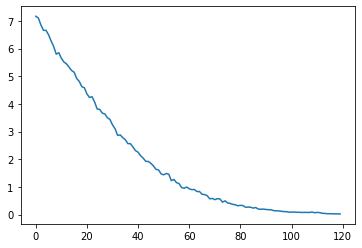

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.show()

In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/VIT SEM/WINTER20-21/E1_CSE1015_MACHINELEARNINGESSENTIALS/PROJECT/FINAL/model.pt')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/VIT SEM/WINTER20-21/E1_CSE1015_MACHINELEARNINGESSENTIALS/PROJECT/FINAL/model.pt'))

<All keys matched successfully>

In [ ]:
def prediction(x):
    for idx in x:
      if idx == 0:
        break
      print(English_vocab.idx2word[int(idx)],end=' ')
    
    print()

    x = x.long().reshape(1,-1).to(device)
    ans = translate(x)
    res = []
    for id in ans:
      res.append(Hindi_vocab.idx2word[id])
    
    return res

In [ ]:
def translate(input):
      #input = batch of english sentences[batch, sentece(padded)]
      with torch.no_grad():
        guess = []
        encoder_states, hidden, cell = model.encoder(input)
        # x = torch.ones((1)).float().to(device) # <START> token
        x = torch.ones((1)).long().to(device)
        while True:
          out, hidden, cell = model.decoder(x, hidden, cell, encoder_states) #out shape = [batch, vocab_size]
          x = out.argmax(1)# taking the word with max value(confidence)  shape = [batch of words]
          guess.append(int(x[0].detach().cpu()))

          if x == 2:
            break

      return guess

In [ ]:
def get_prediction(val):
    keys=np.array([])
    val=val.split()
    for word in val:
        word=word.lower()
        for key, value in English_vocab.idx2word.items():
            if word == value:
                keys=np.append(keys,key)
    keys=np.append(keys,1)
    while(len(keys)!=37):
        keys=np.append(keys,0)
    target=torch.tensor(keys,dtype=torch.float32)
    print(prediction(target))

In [ ]:
get_prediction('i d like to tell you about one such child')

i d like to tell you about one such child <END> 
['मई', 'आपको', 'ऐसे', 'ही', 'एक', 'बच्चे', 'के', 'बारे', 'में', 'बताना', 'चाहूंगी', '<END>']
